In [1]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
#import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta


In [2]:
import pandas_gbq

In [3]:
import numpy_financial as npf

## Ferratum AU Oct 2021

In [5]:
###Manual: adjust book_id and region
book_id='3435712288'
region='au' ###'au' or 'eu'

In [6]:
query_purchase='''SELECT book_id,actual_purchase_price*-1 as purchase_local_ccy,settlement_date,actual_purchase_price_usd
                FROM presentation.dim_books db
                where 1=1
                and book_id='{}' '''.format(book_id)

In [7]:
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [8]:
if region=='au':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_au
            where 1=1
            and book_id='{}' '' '''.format(book_id)
elif region=='eu':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_eu
            where 1=1
            and book_id='{}' '' '''.format(book_id)
else:
    query_cf=None


In [9]:
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [10]:
df_cf_agg = df_cf.groupby(['book_id', 'book_name']).sum().reset_index().copy()

In [12]:
####Removing as of 3rd row the zero values until first non zero
# Find the index of the first non-zero column starting from the third column
non_zero_columns = df_cf_agg.columns[2:]  # Only columns from C onwards
first_non_zero_col = next((col for col in non_zero_columns if df_cf_agg[col].iloc[0] != 0), None)

# Identify columns to drop: from the third column up to the first non-zero column
if first_non_zero_col:
    columns_to_drop = []
    for col in non_zero_columns:
        if col == first_non_zero_col:
            break
        if df_cf_agg[col].iloc[0] == 0.0:
            columns_to_drop.append(col)
    df_cf_agg.drop(columns=columns_to_drop, inplace=True)

In [13]:
book_name=df_cf_agg.iloc[0,1]

In [14]:
cf_values = df_cf_agg.iloc[0, 2:].tolist()

In [15]:
relevant_months=df_cf_agg.columns[2:].tolist()

In [16]:
df_agg_cf_format=pd.DataFrame({'collection':cf_values,'month':relevant_months})

In [17]:
df_agg_cf_format['month_cohort']=range(1, len(df_agg_cf_format)+1)

In [18]:
cashflow=[df_purch.iloc[0,1]]+df_agg_cf_format['collection'].tolist()

In [19]:
cashflow=[round(value, 2) for value in cashflow]

In [20]:
####Calculating dynamic IRR
irr=[]
selected_values=[cashflow[0]]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    irr_temp = round(npf.irr(selected_values),4)
    irr.append(irr_temp)
    
df_agg_cf_format['irr']=irr

In [21]:
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_agg_cf_format['moic']=moic 

In [22]:
df_agg_cf_format['book_id']=book_id
df_agg_cf_format['book_name']=book_name
df_agg_cf_format['purchase_local_ccy']=abs(df_purch.iloc[0,1])
df_agg_cf_format['region']=region.upper()
df_agg_cf_format['purchase_usd']=round(df_purch.iloc[0,3],2)

In [23]:
df_agg_cf_format.head()

,collection,month,month_cohort,irr,moic,book_id,book_name,purchase_local_ccy,region,purchase_usd
0,261402.00,2021-09-01,1,-0.6037,0.40,3435712288,Ferratum / Multitude Oct 21,659683.0,AU,495759.97
1,49947.22,2021-10-01,2,-0.4628,0.47,3435712288,Ferratum / Multitude Oct 21,659683.0,AU,495759.97
2,120861.03,2021-11-01,3,-0.2123,0.66,3435712288,Ferratum / Multitude Oct 21,659683.0,AU,495759.97
3,155443.49,2021-12-01,4,-0.0484,0.89,3435712288,Ferratum / Multitude Oct 21,659683.0,AU,495759.97
4,193742.23,2022-01-01,5,0.0604,1.18,3435712288,Ferratum / Multitude Oct 21,659683.0,AU,495759.97


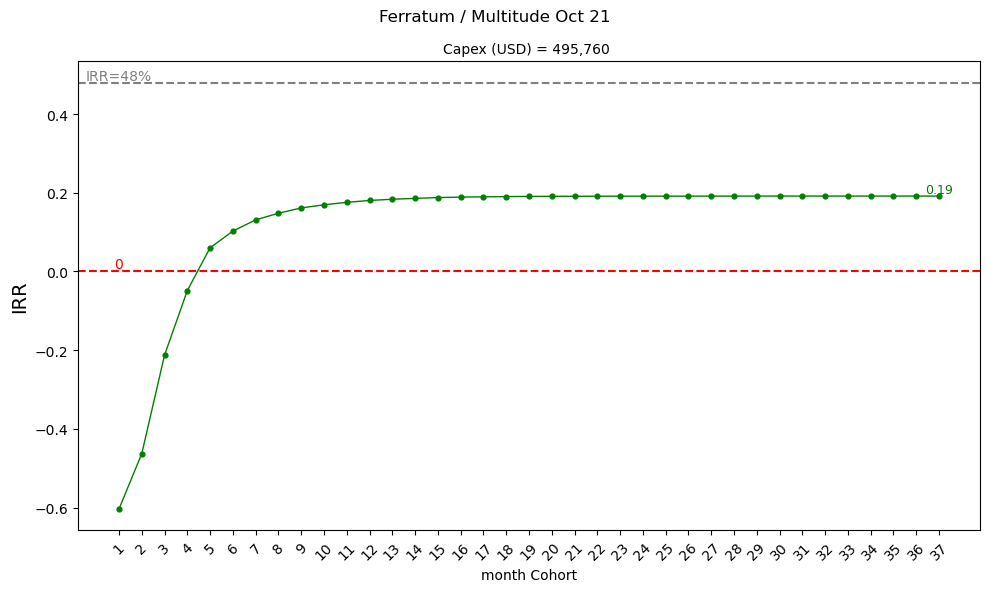

In [24]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['irr']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['irr'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['irr'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 0.48
plt.axhline(y=0.48, color='gray', linestyle='--', label='y = 0.48')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0.48, 'IRR=48%', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

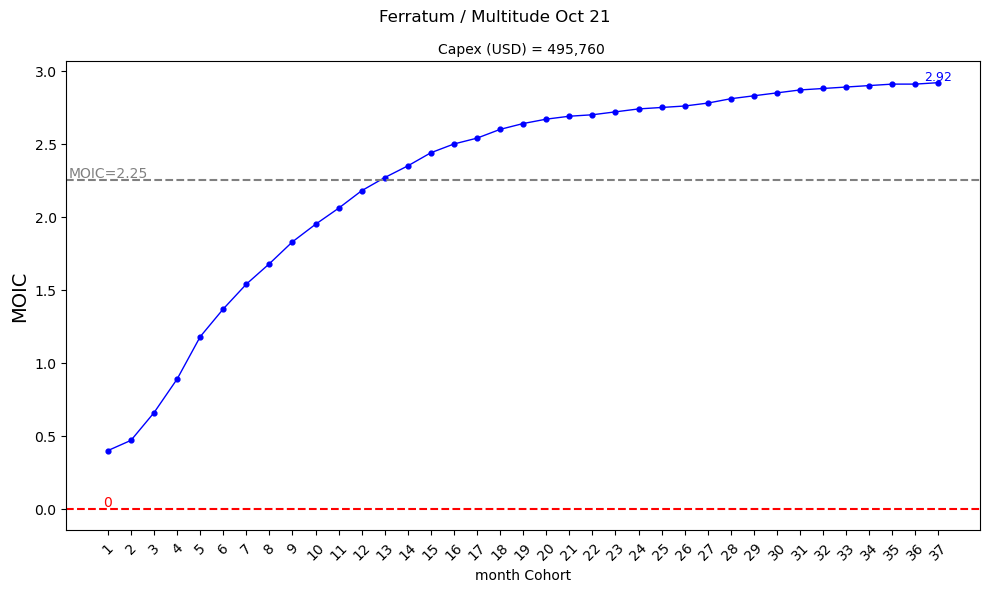

In [25]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('MOIC',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['moic']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['moic'][i], 
#            f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['moic'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9,color='blue')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 2.25
plt.axhline(y=2.25, color='gray', linestyle='--', label='y = 2.25')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 2.25, 'MOIC=2.25', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

## Primagas ES Jan 2023

In [27]:
###Manual: adjust book_id and region
book_id='3791494045'
region='eu' ###'au' or 'eu'

In [28]:
query_purchase='''SELECT book_id,actual_purchase_price*-1 as purchase_local_ccy,settlement_date,actual_purchase_price_usd
                FROM presentation.dim_books db
                where 1=1
                and book_id='{}' '''.format(book_id)
				
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

if region=='au':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_au
            where 1=1
            and book_id='{}' '' '''.format(book_id)
elif region=='eu':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_eu
            where 1=1
            and book_id='{}' '' '''.format(book_id)
else:
    query_cf=None


df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

df_cf_agg = df_cf.groupby(['book_id', 'book_name']).sum().reset_index().copy()

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [29]:
####Removing as of 3rd row the zero values until first non zero
# Find the index of the first non-zero column starting from the third column
non_zero_columns = df_cf_agg.columns[2:]  # Only columns from C onwards
first_non_zero_col = next((col for col in non_zero_columns if df_cf_agg[col].iloc[0] != 0), None)

# Identify columns to drop: from the third column up to the first non-zero column
if first_non_zero_col:
    columns_to_drop = []
    for col in non_zero_columns:
        if col == first_non_zero_col:
            break
        if df_cf_agg[col].iloc[0] == 0.0:
            columns_to_drop.append(col)
    df_cf_agg.drop(columns=columns_to_drop, inplace=True)

In [30]:
book_name=df_cf_agg.iloc[0,1]
cf_values = df_cf_agg.iloc[0, 2:].tolist()
relevant_months=df_cf_agg.columns[2:].tolist()
df_agg_cf_format=pd.DataFrame({'collection':cf_values,'month':relevant_months})
df_agg_cf_format['month_cohort']=range(1, len(df_agg_cf_format)+1)
cashflow=[df_purch.iloc[0,1]]+df_agg_cf_format['collection'].tolist()
cashflow=[round(value, 2) for value in cashflow]
####Calculating dynamic IRR
irr=[]
selected_values=[cashflow[0]]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    irr_temp = round(npf.irr(selected_values),4)
    irr.append(irr_temp)
    
df_agg_cf_format['irr']=irr

#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_agg_cf_format['moic']=moic 

df_agg_cf_format['book_id']=book_id
df_agg_cf_format['book_name']=book_name
df_agg_cf_format['purchase_local_ccy']=abs(df_purch.iloc[0,1])
df_agg_cf_format['region']=region.upper()
df_agg_cf_format['purchase_usd']=round(df_purch.iloc[0,3],2)
df_agg_cf_format.head()

,collection,month,month_cohort,irr,moic,book_id,book_name,purchase_local_ccy,region,purchase_usd
0,2287.71,2023-10-01,1,-0.1508,0.85,3791494045,Primagas Jul-23,2694.04,EU,2939.94
1,3094.32,2023-11-01,2,0.5773,2.00,3791494045,Primagas Jul-23,2694.04,EU,2939.94
2,1105.48,2023-12-01,3,0.6789,2.41,3791494045,Primagas Jul-23,2694.04,EU,2939.94
3,0.00,2024-01-01,4,0.6789,2.41,3791494045,Primagas Jul-23,2694.04,EU,2939.94
4,318.89,2024-02-01,5,0.6881,2.53,3791494045,Primagas Jul-23,2694.04,EU,2939.94


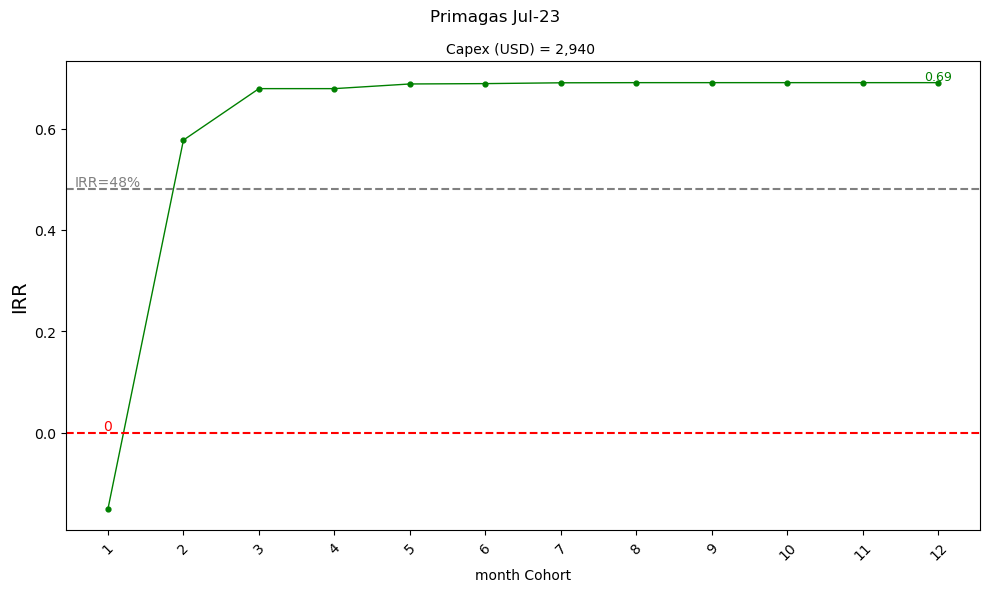

In [31]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['irr']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['irr'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['irr'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 0.48
plt.axhline(y=0.48, color='gray', linestyle='--', label='y = 0.48')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0.48, 'IRR=48%', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

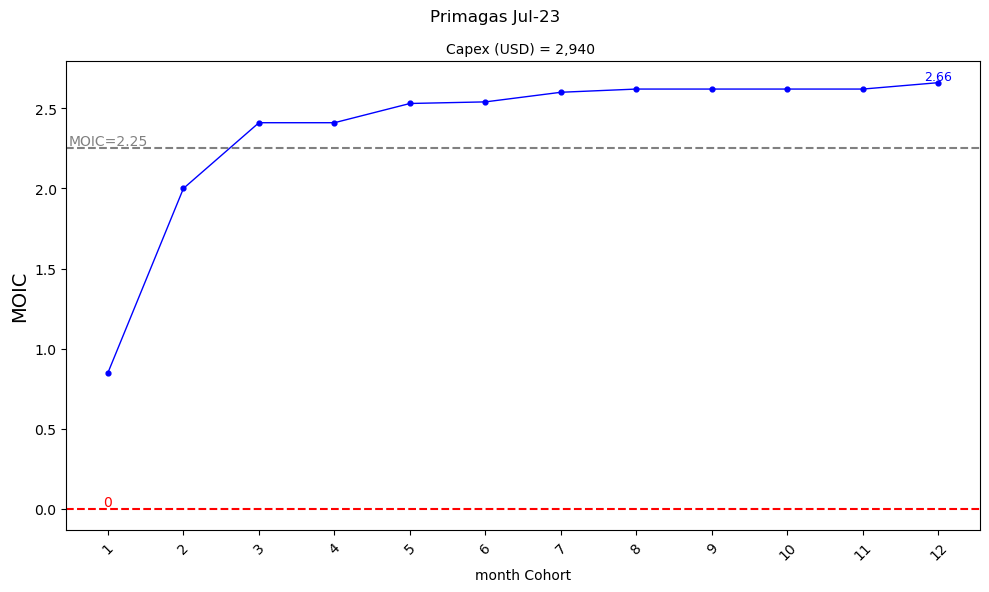

In [32]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('MOIC',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['moic']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['moic'][i], 
#            f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['moic'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9,color='blue')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 2.25
plt.axhline(y=2.25, color='gray', linestyle='--', label='y = 2.25')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 2.25, 'MOIC=2.25', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

## Pagantis ES Sep 2023

In [34]:
###Manual: adjust book_id and region
book_id='5176948179'
region='eu' ###'au' or 'eu'

In [35]:
query_purchase='''SELECT book_id,actual_purchase_price*-1 as purchase_local_ccy,settlement_date,actual_purchase_price_usd
                FROM presentation.dim_books db
                where 1=1
                and book_id='{}' '''.format(book_id)
				
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

if region=='au':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_au
            where 1=1
            and book_id='{}' '' '''.format(book_id)
elif region=='eu':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_eu
            where 1=1
            and book_id='{}' '' '''.format(book_id)
else:
    query_cf=None


df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

df_cf_agg = df_cf.groupby(['book_id', 'book_name']).sum().reset_index().copy()

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [36]:
####Removing as of 3rd row the zero values until first non zero
# Find the index of the first non-zero column starting from the third column
non_zero_columns = df_cf_agg.columns[2:]  # Only columns from C onwards
first_non_zero_col = next((col for col in non_zero_columns if df_cf_agg[col].iloc[0] != 0), None)

# Identify columns to drop: from the third column up to the first non-zero column
if first_non_zero_col:
    columns_to_drop = []
    for col in non_zero_columns:
        if col == first_non_zero_col:
            break
        if df_cf_agg[col].iloc[0] == 0.0:
            columns_to_drop.append(col)
    df_cf_agg.drop(columns=columns_to_drop, inplace=True)

In [37]:
book_name=df_cf_agg.iloc[0,1]
cf_values = df_cf_agg.iloc[0, 2:].tolist()
relevant_months=df_cf_agg.columns[2:].tolist()
df_agg_cf_format=pd.DataFrame({'collection':cf_values,'month':relevant_months})
df_agg_cf_format['month_cohort']=range(1, len(df_agg_cf_format)+1)
cashflow=[df_purch.iloc[0,1]]+df_agg_cf_format['collection'].tolist()
cashflow=[round(value, 2) for value in cashflow]
####Calculating dynamic IRR
irr=[]
selected_values=[cashflow[0]]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    irr_temp = round(npf.irr(selected_values),4)
    irr.append(irr_temp)
    
df_agg_cf_format['irr']=irr

#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_agg_cf_format['moic']=moic 

df_agg_cf_format['book_id']=book_id
df_agg_cf_format['book_name']=book_name
df_agg_cf_format['purchase_local_ccy']=abs(df_purch.iloc[0,1])
df_agg_cf_format['region']=region.upper()
df_agg_cf_format['purchase_usd']=round(df_purch.iloc[0,3],2)
df_agg_cf_format.head()

,collection,month,month_cohort,irr,moic,book_id,book_name,purchase_local_ccy,region,purchase_usd
0,30794.40,2023-11-01,1,-0.8460,0.15,5176948179,PAGAMASTARDE SL - BNPL,200000.0,EU,217064.53
1,67995.35,2023-12-01,2,-0.3349,0.49,5176948179,PAGAMASTARDE SL - BNPL,200000.0,EU,217064.53
2,69869.94,2024-01-01,3,-0.0729,0.84,5176948179,PAGAMASTARDE SL - BNPL,200000.0,EU,217064.53
3,86597.11,2024-02-01,4,0.0916,1.28,5176948179,PAGAMASTARDE SL - BNPL,200000.0,EU,217064.53
4,66186.36,2024-03-01,5,0.1623,1.61,5176948179,PAGAMASTARDE SL - BNPL,200000.0,EU,217064.53


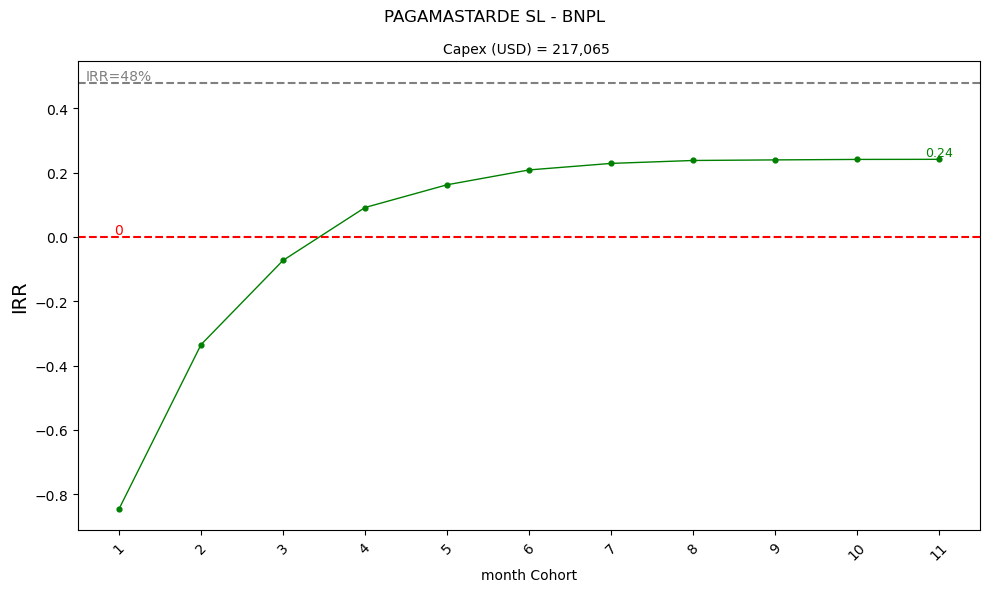

In [38]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['irr']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['irr'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['irr'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 0.48
plt.axhline(y=0.48, color='gray', linestyle='--', label='y = 0.48')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0.48, 'IRR=48%', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

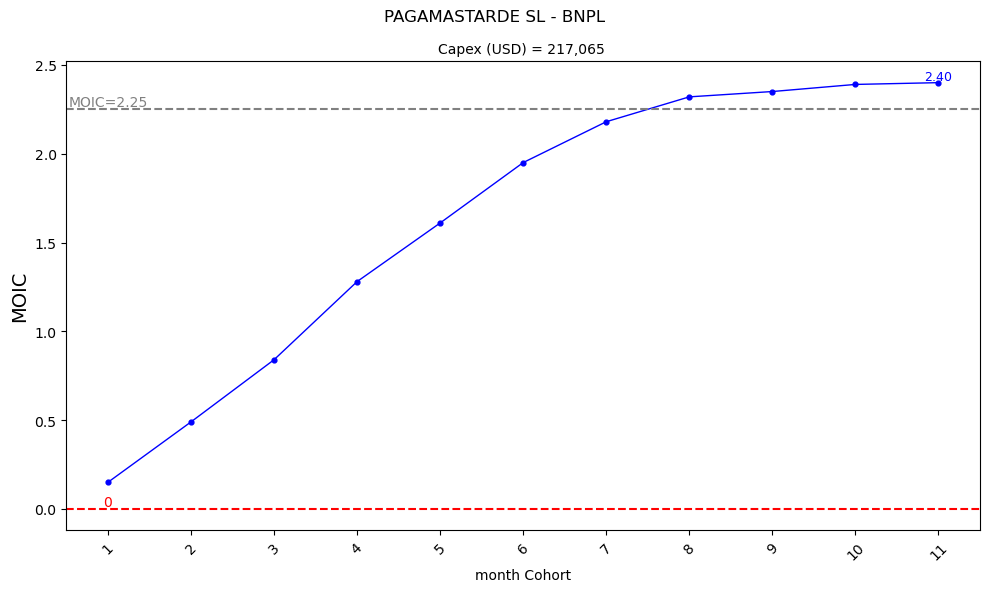

In [39]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('MOIC',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['moic']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['moic'][i], 
#            f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['moic'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9,color='blue')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 2.25
plt.axhline(y=2.25, color='gray', linestyle='--', label='y = 2.25')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 2.25, 'MOIC=2.25', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

## IPF AU Sep 2023

In [41]:
###Manual: adjust book_id and region
book_id='5152696966'
region='au' ###'au' or 'eu'

In [42]:
query_purchase='''SELECT book_id,actual_purchase_price*-1 as purchase_local_ccy,settlement_date,actual_purchase_price_usd
                FROM presentation.dim_books db
                where 1=1
                and book_id='{}' '''.format(book_id)
				
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

if region=='au':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_au
            where 1=1
            and book_id='{}' '' '''.format(book_id)
elif region=='eu':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_eu
            where 1=1
            and book_id='{}' '' '''.format(book_id)
else:
    query_cf=None


df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

df_cf_agg = df_cf.groupby(['book_id', 'book_name']).sum().reset_index().copy()

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [43]:
####Removing as of 3rd row the zero values until first non zero
# Find the index of the first non-zero column starting from the third column
non_zero_columns = df_cf_agg.columns[2:]  # Only columns from C onwards
first_non_zero_col = next((col for col in non_zero_columns if df_cf_agg[col].iloc[0] != 0), None)

# Identify columns to drop: from the third column up to the first non-zero column
if first_non_zero_col:
    columns_to_drop = []
    for col in non_zero_columns:
        if col == first_non_zero_col:
            break
        if df_cf_agg[col].iloc[0] == 0.0:
            columns_to_drop.append(col)
    df_cf_agg.drop(columns=columns_to_drop, inplace=True)

In [44]:
book_name=df_cf_agg.iloc[0,1]
cf_values = df_cf_agg.iloc[0, 2:].tolist()
relevant_months=df_cf_agg.columns[2:].tolist()
df_agg_cf_format=pd.DataFrame({'collection':cf_values,'month':relevant_months})
df_agg_cf_format['month_cohort']=range(1, len(df_agg_cf_format)+1)
cashflow=[df_purch.iloc[0,1]]+df_agg_cf_format['collection'].tolist()
cashflow=[round(value, 2) for value in cashflow]
####Calculating dynamic IRR
irr=[]
selected_values=[cashflow[0]]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    irr_temp = round(npf.irr(selected_values),4)
    irr.append(irr_temp)
    
df_agg_cf_format['irr']=irr

#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_agg_cf_format['moic']=moic 

df_agg_cf_format['book_id']=book_id
df_agg_cf_format['book_name']=book_name
df_agg_cf_format['purchase_local_ccy']=abs(df_purch.iloc[0,1])
df_agg_cf_format['region']=region.upper()
df_agg_cf_format['purchase_usd']=round(df_purch.iloc[0,3],2)
df_agg_cf_format.head()

,collection,month,month_cohort,irr,moic,book_id,book_name,purchase_local_ccy,region,purchase_usd
0,80537.28,2023-11-01,1,-0.4403,0.56,5152696966,IPF Digital SAAC Oct 23,143902.72,AU,91204.61
1,30025.96,2023-12-01,2,-0.1845,0.77,5152696966,IPF Digital SAAC Oct 23,143902.72,AU,91204.61
2,15786.99,2024-01-01,3,-0.0826,0.88,5152696966,IPF Digital SAAC Oct 23,143902.72,AU,91204.61
3,15729.58,2024-02-01,4,-0.0072,0.99,5152696966,IPF Digital SAAC Oct 23,143902.72,AU,91204.61
4,20523.17,2024-03-01,5,0.0595,1.13,5152696966,IPF Digital SAAC Oct 23,143902.72,AU,91204.61


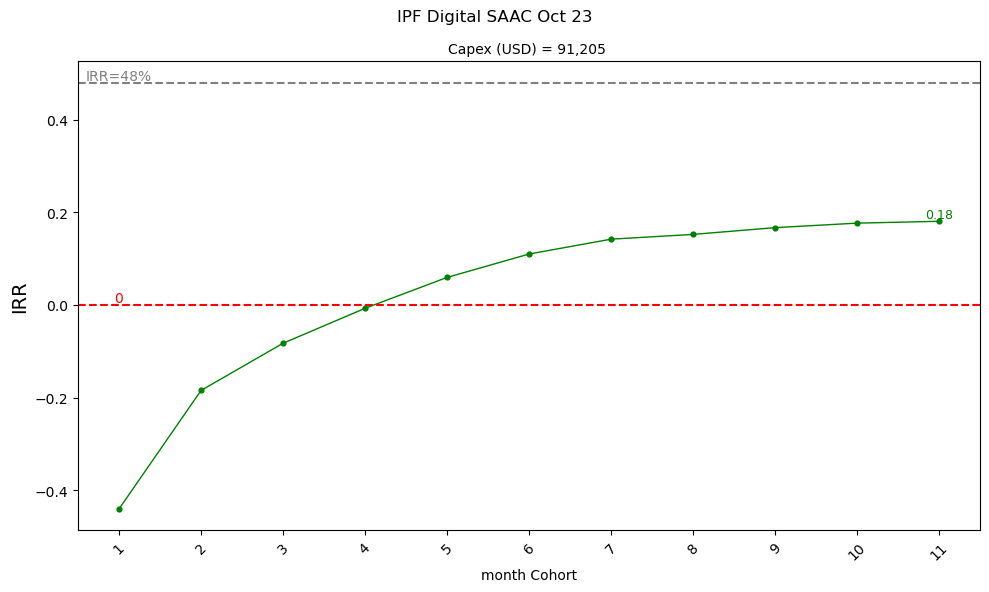

In [45]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('IRR',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['irr']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['irr'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['irr'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 0.48
plt.axhline(y=0.48, color='gray', linestyle='--', label='y = 0.48')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0.48, 'IRR=48%', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

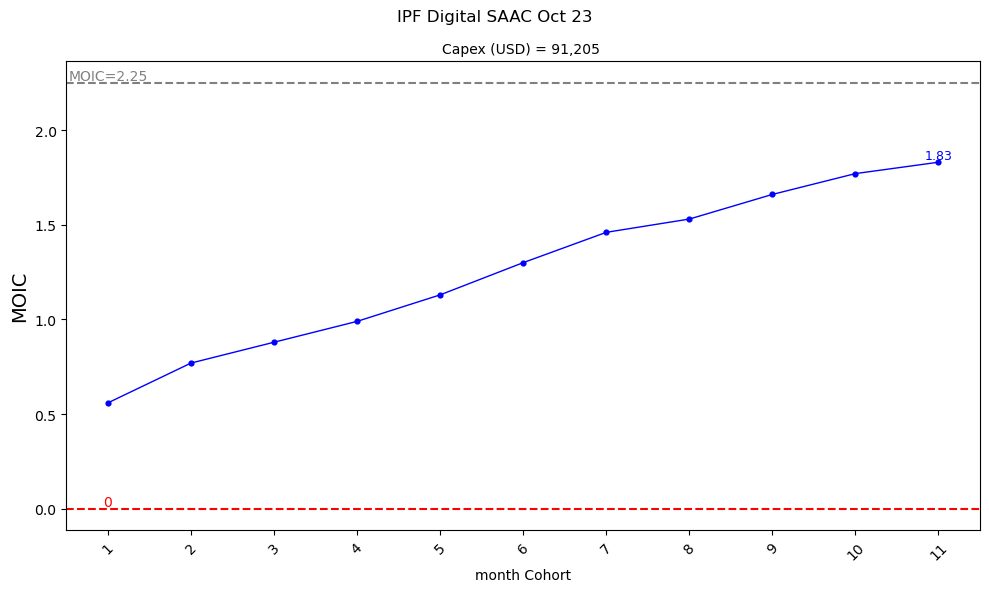

In [46]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue',s=12)

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('MOIC',fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0,3]),0), fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['moic']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['moic'][i], 
#            f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Get the last value for annotation
last_x = df_agg_cf_format['month_cohort'].iloc[-1]
last_y = df_agg_cf_format['moic'].iloc[-1]
# Add a label for the last point
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9,color='blue')

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 2.25
plt.axhline(y=2.25, color='gray', linestyle='--', label='y = 2.25')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 2.25, 'MOIC=2.25', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()